In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
import seaborn as sns
import pandas as pd
import corner
import scipy.stats as stats
from tqdm import tqdm

from msc.plot_utils import set_size
from msc.config_utils import config

plt.style.use(['science', 'no-latex'])
plt.viridis()


/home/noamsi/.conda/envs/msc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 252x189 with 0 Axes>

In [2]:
# generate data
n_samples = 100 * np.array([600, 400, 1])
centers = np.array([[0], [3], [5]])
X, y = make_blobs(n_samples=n_samples, centers=centers, n_features=1, random_state=0)


In [3]:
# discretize for histogram
bins = np.linspace(-8, 8, 100, endpoint=True)
count, bins = np.histogram(X, bins=bins)


In [4]:
# fit density estimation
gmm = GaussianMixture(2)
gmm.fit(X)


GaussianMixture(n_components=2)

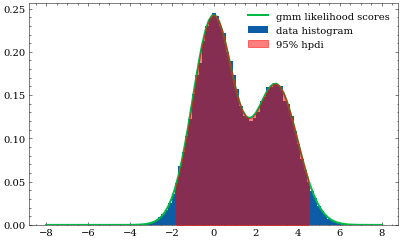

In [5]:
# plot density log likelihood
width = 478  # pt
fig, axes = plt.subplots(1, figsize=set_size(width))

theta = bins
scores = gmm.score_samples(theta.reshape(-1, 1))

axes.hist(X, bins=bins, label='data histogram', density=True, zorder=2)
axes.plot(theta, np.exp(scores), label='gmm likelihood scores', lw=2, zorder=2)

# plot highest posterior density interval 
ci = numpyro.diagnostics.hpdi(X, 0.95)
hdpi_x = np.linspace(ci[0], ci[1], 100).squeeze()
hdpi_scores = gmm.score_samples(hdpi_x.reshape(-1,1))

axes.fill_between(hdpi_x, np.exp(hdpi_scores), label="95% hpdi", color='r', alpha=0.5, zorder=3)
axes.legend()

plt.show()

In [6]:
ci

array([[-1.80219269],
       [ 4.48082753]])

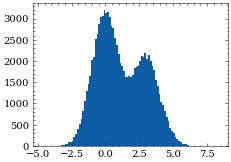

In [7]:
plt.hist(np.array(gmm.sample(100000)[0]).reshape(-1,1), bins=100);

sampling from gmm with mcmc

In [8]:
def mh_mcmc(N=int(1e5)):
  samples = []
  theta = 0
  for i in tqdm(range(N)):
    proposal_func = lambda x: stats.norm.rvs(loc=x, scale=1)
    theta_prime = np.array([proposal_func(theta)]).reshape(1,1)
    log_likelihood = gmm.score(theta_prime)
    r = np.random.uniform()
    if log_likelihood > np.log(r):
      theta = theta_prime
    samples.append(theta)
  return np.array(samples)

In [9]:
mcmc_samples = mh_mcmc()

100%|██████████| 100000/100000 [00:37<00:00, 2641.08it/s]
/tmp/ipykernel_45578/4034495958.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(samples)


In [10]:
mcmc_samples.shape

(100000,)

In [11]:
gmm_samples = gmm.sample(1e5)[0].squeeze()

In [12]:
stats.describe(mcmc_samples)

DescribeResult(nobs=100000, minmax=(array([[-3.25274964]]), array([[6.06706969]])), mean=array([[1.37174096]]), variance=array([[3.27768441]]), skewness=array([[0.15203476]]), kurtosis=array([[-0.95378602]]))

In [13]:
stats.describe(gmm_samples)

DescribeResult(nobs=100000, minmax=(-4.219018892118012, 6.838871856366878), mean=1.2078096153486109, variance=3.1899863727847517, skewness=0.23827956427578018, kurtosis=-0.8738678466664629)

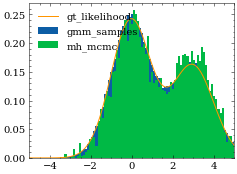

In [14]:
plt.hist(gmm_samples, bins=np.linspace(-5, 5, 100),  density=True, label='gmm_samples')
plt.hist(mcmc_samples, bins=np.linspace(-5, 5, 100), density=True, label='mh_mcmc');
# plt.yscale('log')
plt.xlim(-5, 5)
x = np.linspace(-5, 5, 100)
plt.plot(x, np.exp(gmm.score_samples(x.reshape(-1, 1))), label='gt_likelihood')
plt.legend()
plt.tight_layout();

In [15]:
mcmc_ci = numpyro.diagnostics.hpdi(mcmc_samples, 0.95)
mcmc_ci
# hdpi_x = np.linspace(ci[0], ci[1], 100).squeeze()
# hdpi_scores = gmm.score_samples(hdpi_x.reshape(-1,1))
# axes.fill_between(hdpi_x, np.exp(hdpi_scores), label="95% hpdi", color='r', alpha=0.5, zorder=3)

array([array([[-1.6352741]]), array([[4.57803117]])], dtype=object)

In [16]:
gmm_ci = numpyro.diagnostics.hpdi(gmm_samples.squeeze(), 0.95)
gmm_ci

array([-1.78192197,  4.48248209])

In [17]:
mse = np.mean((mcmc_ci - gmm_ci)**2)
mse

array([[0.01531761]])